In [29]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
from model_components.models import FourierPINNsFormer
from model_components.util import *
import scipy.io

In [30]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [32]:
model = FourierPINNsFormer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2, mapping_size=64).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))
n_params = get_n_params(model)

FourierPINNsFormer(
  (embedding): EnhancedEmbedding(
    (fourier): FourierFeatures()
    (linear): Linear(in_features=128, out_features=32, bias=True)
    (pos_emb): Linear(in_features=2, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (linear_out): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): WaveAct()
    (2): Linear(in_

/tmp/ipykernel_531839/1725142899.py:25: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


In [33]:
kernel_size = 300

D1 = kernel_size
D2 = len(x_left)
D3 = len(x_lower)

def compute_ntk(J1, J2):
    Ker = torch.matmul(J1, torch.transpose(J2, 0, 1))
    return Ker

In [34]:
loss_track = []

progress_bar = tqdm(range(1000))

w1, w2, w3 = 1, 1, 1

for i in progress_bar:
    
    if i % 20 == 0:
        J1 = torch.zeros((D1, n_params))
        J2 = torch.zeros((D2, n_params))
        J3 = torch.zeros((D3, n_params))

        batch_ind = np.random.choice(len(x_res), kernel_size, replace=False)
        x_train, t_train = x_res[batch_ind], t_res[batch_ind]

        pred_res = model(x_train, t_train)
        pred_left = model(x_left, t_left)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        for j in range(len(x_train)):
            model.zero_grad()
            pred_res[j,0].backward(retain_graph=True)
            J1[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])


        for j in range(len(x_left)):
            model.zero_grad()
            pred_left[j,0].backward(retain_graph=True)
            J2[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])

        for j in range(len(x_lower)):
            model.zero_grad()
            pred_lower[j,0].backward(retain_graph=True)
            pred_upper[j,0].backward(retain_graph=True)
            J3[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])

        K1 = torch.trace(compute_ntk(J1, J1))
        K2 = torch.trace(compute_ntk(J2, J2))
        K3 = torch.trace(compute_ntk(J3, J3))
        
        K = K1+K2+K3

        w1 = K.item() / K1.item()
        w2 = K.item() / K2.item()
        w3 = K.item() / K3.item()
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + 50 * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = w1 * loss_res + w2 * loss_bc + w3 * loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    optim.step(closure)
    
    last_loss = loss_track[-1]
    progress_bar.set_postfix({
        "res": f"{last_loss[0]:.6f}",
        "bc": f"{last_loss[1]:.6f}",
        "ic": f"{last_loss[2]:.6f}",
    })

100%|██████████| 1000/1000 [22:25<00:00,  1.35s/it, res=0.001000, bc=0.000029, ic=0.000018]


In [35]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.001000, Loss_BC: 0.000029, Loss_IC: 0.000018
Train Loss: 0.001047


relative L1 error: 0.017559
relative L2 error: 0.020670


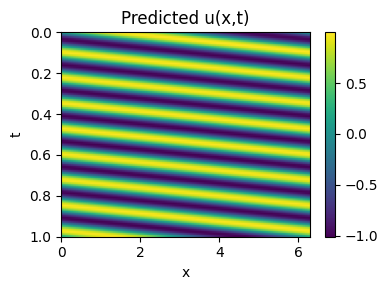

In [36]:
# Visualize PINNsformerz
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]


with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('./convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

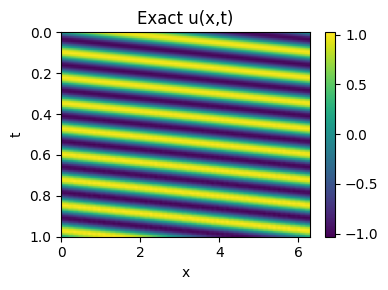

In [37]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

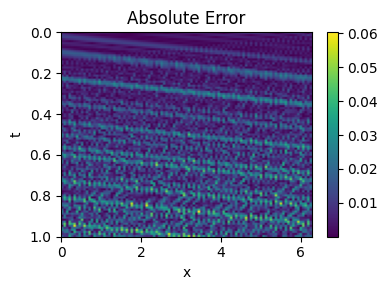

In [38]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), 'PINNsformer_fourier_expanded.pt')